
# MAP — Charting Student Math Misunderstandings: Baseline (TF‑IDF + Linear)
**Goal:** predict up to **3** `Category:Misconception` labels per row to maximize **MAP@3**.

**Approach:** concatenate problem text, student MC answer, and their explanation → TF‑IDF → linear classifier (SGD `log_loss`).  
We evaluate with **GroupKFold** split by `QuestionId` to reduce leakage, then train on full data and create **`submission.csv`**.


In [1]:
import os, gc
import numpy as np
import pandas as pd

from sklearn.model_selection import GroupKFold
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import SGDClassifier
from sklearn.pipeline import Pipeline, FeatureUnion
from sklearn.metrics import confusion_matrix, classification_report

import matplotlib.pyplot as plt

np.random.seed(42)

# MAP@K metric (K=3 per competition)
def apk(actual, predicted, k=3):
    """Average precision at k for a single observation.
    `actual` is a single-element list [true_label] (competition has one truth per row).
    `predicted` is an ordered list of labels (top-k predictions).
    """
    if not actual:
        return 0.0
    if k < len(predicted):
        predicted = predicted[:k]
    score = 0.0
    num_hits = 0.0
    for i, p in enumerate(predicted):
        if p == actual[0]:
            num_hits += 1.0
            score += num_hits / (i + 1.0)
            break  # only one relevant label per row
    return score

def mapk(actual_list, predicted_list, k=3):
    return np.mean([apk([a], p, k) for a, p in zip(actual_list, predicted_list)])

def topk_from_proba(class_labels, proba_row, k=3):
    idx = np.argsort(-proba_row)[:k]
    return [class_labels[i] for i in idx]

print("Libraries loaded.")

Libraries loaded.


## Load Data

In [2]:
# Detect Kaggle input path
KAGGLE_INPUT = '/kaggle/input/map-charting-student-math-misunderstandings'
LOCAL_INPUT  = '../input/map-charting-student-math-misunderstandings'
HERE = os.getcwd()

if os.path.exists(KAGGLE_INPUT):
    DATA_DIR = KAGGLE_INPUT
elif os.path.exists(LOCAL_INPUT):
    DATA_DIR = LOCAL_INPUT
else:
    # Fallback to working directory (for local testing with provided CSVs)
    DATA_DIR = 'data'

print('DATA_DIR =', DATA_DIR)

train = pd.read_csv(os.path.join(DATA_DIR, "train.csv"))
test = pd.read_csv(os.path.join(DATA_DIR, "test.csv"))
print(train.shape, test.shape)
train.head(2)

DATA_DIR = data
(36696, 7) (3, 5)


,row_id,QuestionId,QuestionText,MC_Answer,StudentExplanation,Category,Misconception
0,0,31772,What fraction of the shape is not shaded? Give...,\( \frac{1}{3} \),0ne third is equal to tree nineth,True_Correct,NaN
1,1,31772,What fraction of the shape is not shaded? Give...,\( \frac{1}{3} \),1 / 3 because 6 over 9 is 2 thirds and 1 third...,True_Correct,NaN


## Prepare data

In [3]:
# Build single target label "Category:Misconception"
train['Misconception'] = train['Misconception'].fillna('NA')
train['target'] = train['Category'].astype(str) + ':' + train['Misconception'].astype(str)

# Text features: concatenate question, MC answer, and explanation
def combine_text(df):
    return (
        df['QuestionText'].fillna('') + ' [MC] ' +
        df['MC_Answer'].fillna('') + ' [EXPL] ' +
        df['StudentExplanation'].fillna('')
    )

X_text = combine_text(train)
X_test_text = combine_text(test)

y = train['target'].values
groups = train['QuestionId'].values

print('Unique classes:', len(np.unique(y)))
print('Example label:', y[0])
print('Text example:', X_text.iloc[0][:300])

Unique classes: 65
Example label: True_Correct:NA
Text example: What fraction of the shape is not shaded? Give your answer in its simplest form. [Image: A triangle split into 9 equal smaller triangles. 6 of them are shaded.] [MC] \( \frac{1}{3} \) [EXPL] 0ne third is equal to tree nineth


## Explore data

Counts (sorted): [14802  6542  5265  1446   891   698   618   564   550   412   409   409
   345   332   328   306   291   282   273   227   198   179   162   153
   128    97    96    93    88    74    58    51    50    38    23    23
    22    21    18    17    11     8     8     8     8     8     7     6
     6     6     6     5     5     4     4     3     3     2     2     2
     1     1     1     1     1]


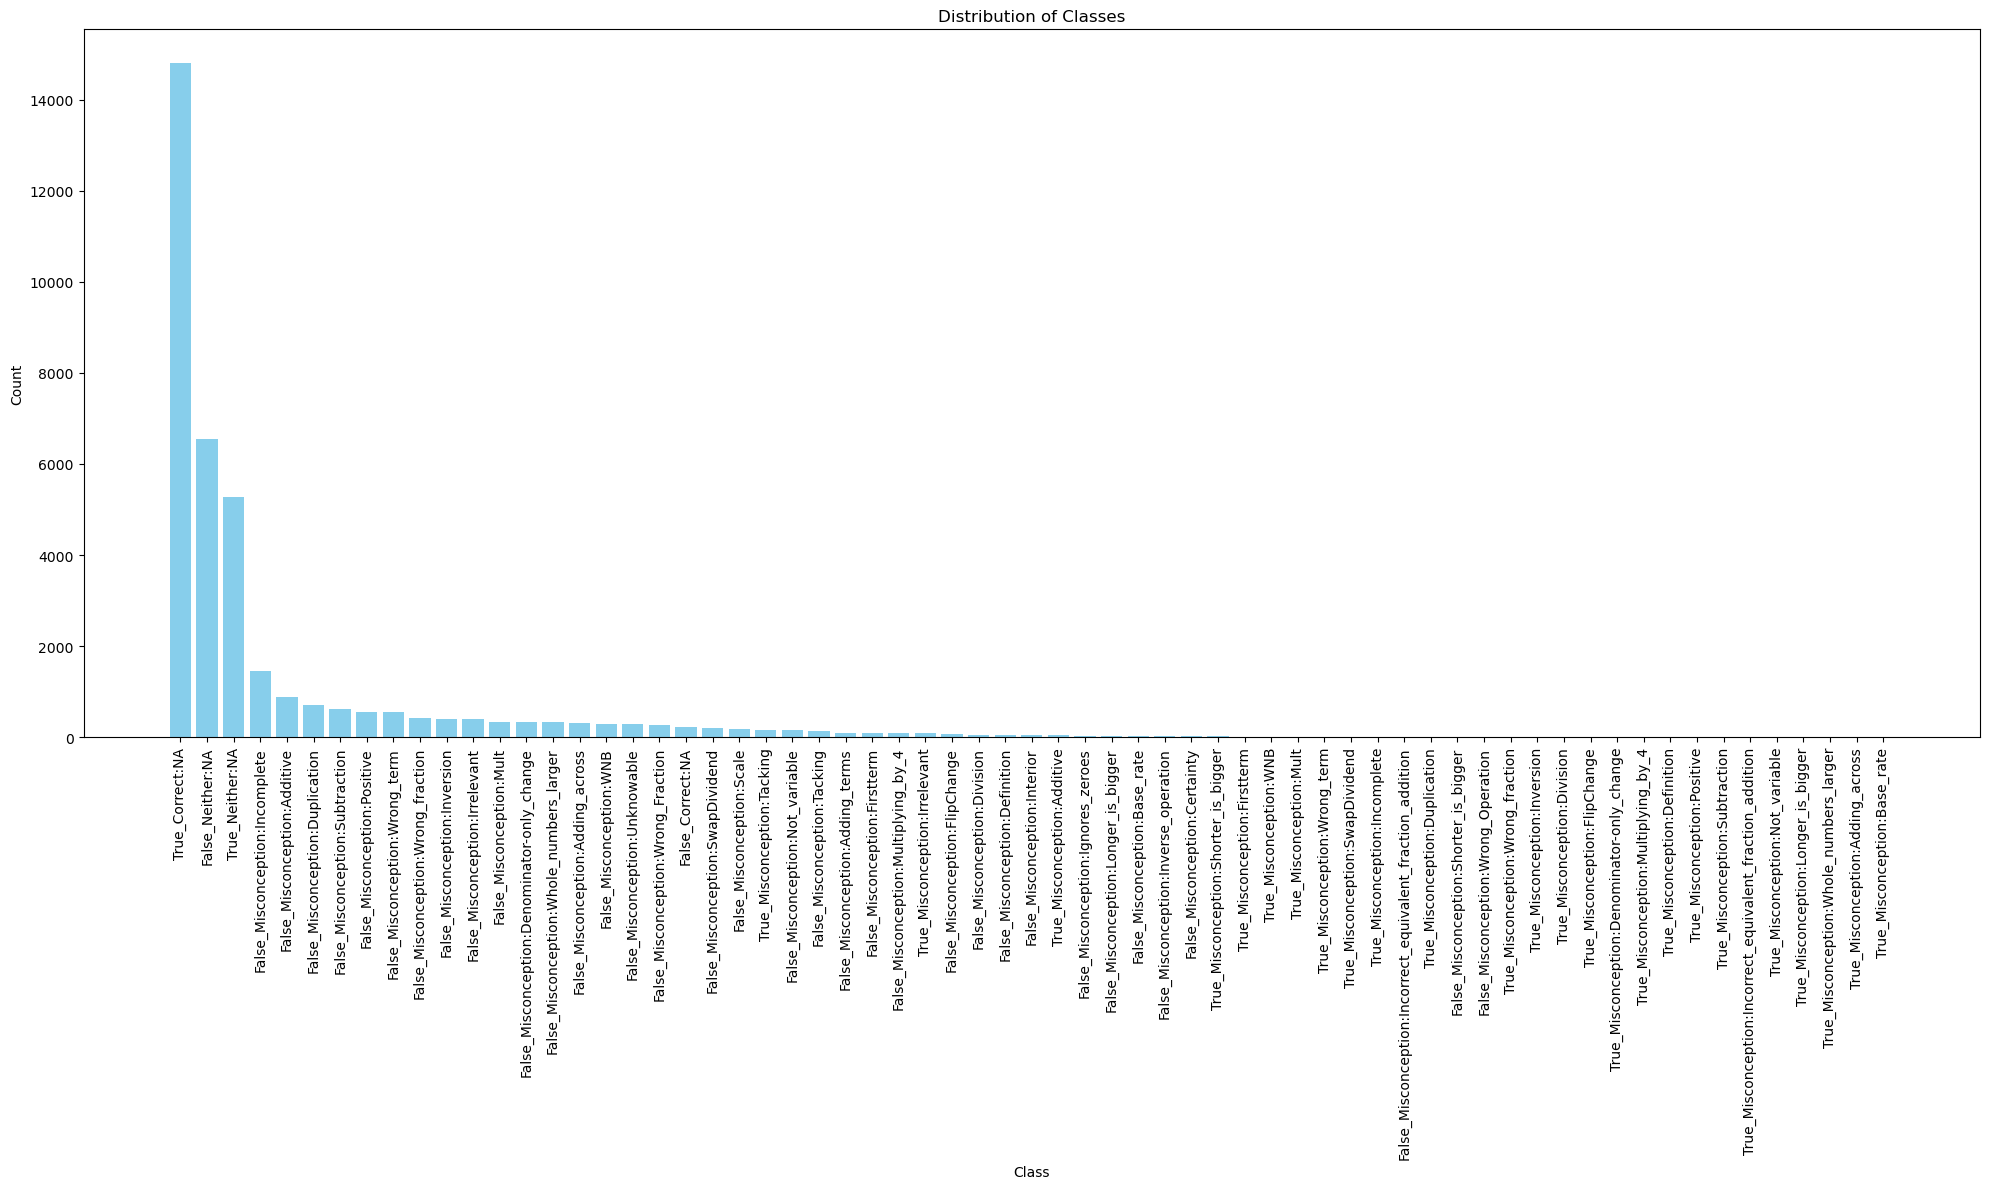

In [ ]:
# Find the unique classes and their counts
classes, counts = np.unique(y, return_counts=True)

# Sort the counts and classes in descending order
sorted_indices = np.argsort(counts)[::-1]
sorted_classes = classes[sorted_indices]
sorted_counts = counts[sorted_indices]

# Create a bar chart for visualization
plt.figure(figsize=(20, 12))
plt.bar(sorted_classes.astype(str), sorted_counts, color="skyblue")
plt.title("Distribution of Classes")
plt.xlabel("Class")
plt.ylabel("Count")
plt.xticks(rotation=90)
plt.tight_layout()

print("Counts (sorted):", sorted_counts)

## Model Pipeline

In [5]:
# A simple but strong baseline:
# - Char-level TF-IDF (3-5 grams)
# - Word-level TF-IDF (1-2 grams)
# - SGDClassifier with log_loss to get predict_proba for many classes efficiently

# Word-level pipeline
word_pipeline = Pipeline(
    [
        (
            "vectorizer",
            TfidfVectorizer(
                analyzer="word",
                lowercase=True,
                strip_accents="unicode",
                ngram_range=(1, 2),
                max_features=250_000,
                min_df=2,
            ),
        ),
    ]
)

# Character-level pipeline
char_pipeline = Pipeline(
    [
        (
            "vectorizer",
            TfidfVectorizer(
                lowercase=True,
                strip_accents="unicode",
                analyzer="char_wb",
                ngram_range=(3, 5),
                max_features=250_000,
                min_df=2,
            ),
        ),
    ]
)

# Combine both pipelines using FeatureUnion
combined_features = FeatureUnion(
    [("word_features", word_pipeline), ("char_features", char_pipeline)]
)

pipeline = Pipeline(
    [
        ("features", combined_features),
        (
            "clf",
            SGDClassifier(
                loss="log_loss",
                penalty="l2",
                alpha=1e-5,
                max_iter=10_000,
                tol=1e-4,
                random_state=42,
            ),
        ),
    ]
)

pipeline

Pipeline(steps=[('features',
                 FeatureUnion(transformer_list=[('word_features',
                                                 Pipeline(steps=[('vectorizer',
                                                                  TfidfVectorizer(max_features=250000,
                                                                                  min_df=2,
                                                                                  ngram_range=(1,
                                                                                               2),
                                                                                  strip_accents='unicode'))])),
                                                ('char_features',
                                                 Pipeline(steps=[('vectorizer',
                                                                  TfidfVectorizer(analyzer='char_wb',
                                                                                  max_features=250000,
                                                                                  min_df=2,
                                                                                  ngram_range=(3,
                                                                                               5),
                                                                                  strip_accents='unicode'))]))])),
                ('clf',
                 SGDClassifier(alpha=1e-05, loss='log_loss', max_iter=10000,
                               random_state=42, tol=0.0001))])

## Evaluation

### Cross-Validation

In [6]:
N_FOLDS = 5
gkf = GroupKFold(n_splits=N_FOLDS)

oof_true = []
oof_pred_single = []
oof_pred_topk = []

for fold, (tr_idx, va_idx) in enumerate(gkf.split(X_text, y, groups), 1):
    X_tr, X_va = X_text.iloc[tr_idx], X_text.iloc[va_idx]
    y_tr, y_va = y[tr_idx], y[va_idx]

    model = pipeline
    model.fit(X_tr, y_tr)

    # Predict probabilities for validation
    proba = model.predict_proba(X_va)
    classes = model.named_steps['clf'].classes_

    # Single predictions (highest probability)
    pred_single = model.predict(X_va)

    # Top-k predictions for MAP@3
    pred_topk = [topk_from_proba(classes, row, k=3) for row in proba]

    oof_true.extend(list(y_va))
    oof_pred_single.extend(pred_single)
    oof_pred_topk.extend(pred_topk)

    fold_map3 = mapk(list(y_va), pred_topk, k=3)
    print(f"Fold {fold} MAP@3: {fold_map3:.5f}")
    gc.collect()

cv_map3 = mapk(oof_true, oof_pred_topk, k=3)
print(f"\nCV MAP@3 (mean over out-of-fold): {cv_map3:.5f}")

Fold 1 MAP@3: 0.59504
Fold 2 MAP@3: 0.28257
Fold 3 MAP@3: 0.52185
Fold 4 MAP@3: 0.50964
Fold 5 MAP@3: 0.39390

CV MAP@3 (mean over out-of-fold): 0.46321


### Top-k confusion analysis

In [7]:
def analyze_topk_predictions(y_true, y_pred_topk, k=3):
    """Analyze how often true labels appear in top-k predictions"""
    correct_at_k = []
    
    for true_label, pred_topk in zip(y_true, y_pred_topk):
        if true_label in pred_topk:
            position = pred_topk.index(true_label) + 1  # 1-indexed
            correct_at_k.append(position)
        else:
            correct_at_k.append(0)  # Not in top-k
    
    print(f"\n=== Top-{k} Prediction Analysis ===")
    for pos in range(1, k+1):
        count = sum(1 for x in correct_at_k if x == pos)
        pct = count / len(correct_at_k) * 100
        print(f"Correct at position {pos}: {count} ({pct:.1f}%)")
    
    not_in_topk = sum(1 for x in correct_at_k if x == 0)
    pct_not_in_topk = not_in_topk / len(correct_at_k) * 100
    print(f"Not in top-{k}: {not_in_topk} ({pct_not_in_topk:.1f}%)")

analyze_topk_predictions(oof_true, oof_pred_topk, k=3)


=== Top-3 Prediction Analysis ===
Correct at position 1: 12805 (34.9%)
Correct at position 2: 6277 (17.1%)
Correct at position 3: 3163 (8.6%)
Not in top-3: 14451 (39.4%)


### Analyze misclassifications in detail

In [8]:
def analyze_misclassifications(y_true, y_pred, classes):
    cm = confusion_matrix(y_true, y_pred, labels=classes)

    # Percentage confusion matrix
    cm_pct = cm.astype("float") / cm.sum(axis=1)[:, np.newaxis] * 100

    # Create summary table for each class
    summary_data = []

    for i, true_class in enumerate(classes):
        total_samples = cm[i].sum()
        correct_predictions = cm[i, i]
        misclassifications = total_samples - correct_predictions

        if total_samples > 0:
            misclassification_rate = (misclassifications / total_samples) * 100
            accuracy = (correct_predictions / total_samples) * 100

            # Find most frequent wrong prediction
            wrong_predictions = [
                (classes[j], cm[i, j], cm_pct[i, j])
                for j in range(len(classes))
                if i != j and cm[i, j] > 0
            ]

            if wrong_predictions:
                # Sort by count (not percentage) to find most frequent error
                most_frequent_error = max(wrong_predictions, key=lambda x: x[1])
                most_frequent_error_class = most_frequent_error[0]
                most_frequent_error_count = most_frequent_error[1]
                most_frequent_error_pct = most_frequent_error[2]
            else:
                most_frequent_error_class = "None"
                most_frequent_error_count = 0
                most_frequent_error_pct = 0.0

            summary_data.append(
                {
                    "True_Class": true_class,
                    "Total_Samples": total_samples,
                    "Correct": correct_predictions,
                    "Accuracy_%": accuracy,
                    "Misclassified": misclassifications,
                    "Misclassification_%": misclassification_rate,
                    "Most_Frequent_Error": most_frequent_error_class,
                    "Error_Count": most_frequent_error_count,
                    "Error_%_of_Class": most_frequent_error_pct,
                }
            )

    # Create summary DataFrame
    summary_df = pd.DataFrame(summary_data)

    # Sort by misclassification rate (worst performing classes first)
    summary_df = summary_df.sort_values("Misclassified", ascending=False)

    print("=== Class-by-Class Misclassification Analysis ===")
    print("(Sorted by misclassification - worst first)")
    print()
    print(summary_df.to_string(index=False, float_format="%.1f"))

all_classes = sorted(set(oof_true))
analyze_misclassifications(oof_true, oof_pred_single, all_classes)

=== Class-by-Class Misclassification Analysis ===
(Sorted by misclassification - worst first)

                                                True_Class  Total_Samples  Correct  Accuracy_%  Misclassified  Misclassification_%                Most_Frequent_Error  Error_Count  Error_%_of_Class
                                           True_Correct:NA          14802     7871        53.2           6931                 46.8                   False_Neither:NA         5250              35.5
                                           True_Neither:NA           5265     1024        19.4           4241                 80.6                   False_Neither:NA         2305              43.8
                                          False_Neither:NA           6542     3910        59.8           2632                 40.2                    True_Neither:NA         1261              19.3
                            False_Misconception:Incomplete           1446        0         0.0           1446        

## Full Dataset Training

In [9]:
final_model = pipeline
final_model.fit(X_text, y)

Pipeline(steps=[('features',
                 FeatureUnion(transformer_list=[('word_features',
                                                 Pipeline(steps=[('vectorizer',
                                                                  TfidfVectorizer(max_features=250000,
                                                                                  min_df=2,
                                                                                  ngram_range=(1,
                                                                                               2),
                                                                                  strip_accents='unicode'))])),
                                                ('char_features',
                                                 Pipeline(steps=[('vectorizer',
                                                                  TfidfVectorizer(analyzer='char_wb',
                                                                                  max_features=250000,
                                                                                  min_df=2,
                                                                                  ngram_range=(3,
                                                                                               5),
                                                                                  strip_accents='unicode'))]))])),
                ('clf',
                 SGDClassifier(alpha=1e-05, loss='log_loss', max_iter=10000,
                               random_state=42, tol=0.0001))])

## Test prediction and Kaggle Submission

In [10]:
test_proba = final_model.predict_proba(X_test_text)
classes = final_model.named_steps['clf'].classes_

top3 = [topk_from_proba(classes, row, k=3) for row in test_proba]

# Build submission
sub = pd.DataFrame({
    'row_id': test.index + 36696,  # Kaggle's sample_submission starts at this ID; we re-index safely
    'Category:Misconception': [' '.join(t) for t in top3]
})
sub.head()

,row_id,Category:Misconception
0,36696,True_Correct:NA True_Neither:NA False_Neither:NA
1,36697,False_Misconception:WNB False_Neither:NA False...
2,36698,True_Neither:NA True_Correct:NA False_Neither:NA


In [11]:
# Use the provided sample_submission to ensure exact row_id ordering
sample_path = os.path.join(DATA_DIR, 'sample_submission.csv')
if os.path.exists(sample_path):
    sample = pd.read_csv(sample_path)
    if 'row_id' in sample.columns:
        sub = sample[['row_id']].merge(sub, on='row_id', how='left')
        # If any rows didn't merge (shouldn't happen), fill with a safe default
        default_label = 'True_Correct:NA'
        sub['Category:Misconception'] = sub['Category:Misconception'].fillna(default_label)
        print('Aligned with sample_submission.')
else:
    print('sample_submission.csv not found; using generated row_id sequence.')

sub.head(3)

Aligned with sample_submission.


,row_id,Category:Misconception
0,36696,True_Correct:NA True_Neither:NA False_Neither:NA
1,36697,False_Misconception:WNB False_Neither:NA False...
2,36698,True_Neither:NA True_Correct:NA False_Neither:NA


In [12]:

SUB_PATH = 'submission.csv'
sub.to_csv(SUB_PATH, index=False)
print('Saved:', os.path.abspath(SUB_PATH))
sub.head()

Saved: /home/martin/Workspace/map-charting-student-math-misunderstandings/submission.csv


,row_id,Category:Misconception
0,36696,True_Correct:NA True_Neither:NA False_Neither:NA
1,36697,False_Misconception:WNB False_Neither:NA False...
2,36698,True_Neither:NA True_Correct:NA False_Neither:NA



## Notes & Next Steps
- This is a **clean baseline**; strong gains often come from:
  - [x] Adding **character-level TF‑IDF** features (e.g., char 3–5 grams) and stacking with word TF‑IDF.
  - [ ] Using **class-weighting** to handle long-tail misconception labels.
  - [ ] Ensembling multiple linear models or adding **lightweight neural** encoders (e.g., MiniLM) with pooling.
  - [ ] Normalizing math expressions / symbols; including `QuestionId`‑aware features.

- Keep runtime low and avoid leakage (we grouped by `QuestionId` for CV).
- Submit this notebook as **GPU/CPU (no internet)**. The output `submission.csv` is in the working directory.
